In [40]:
import pandas as pd
import random
from pathlib import Path
"counterfactual_results/nf=300_fl=24_nt=10_nt=30_ne=5_kt=0.33_re=False_gemma-2-9b"
"counterfactual_results/nf=300_fl=32_nt=10_nt=30_ne=5_kt=0.5_re=False_gemma-2-9b/generations_scores.json"
kl_path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_kt={kl_threshold}_re={random_explanations}_l={latents}_{model_last}"
zero_ablation_path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_re={random_explanations}_l={latents}_za={zero_ablate}_{model_last}"

base_cfg = {
    "feat_layer": 32,
    "n_feats": 300,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 1.0,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
    "latents": "sae",
    "zero_ablate": False
}

def convert_to_single_explanation(df):
    df = df.copy()
    df["explanations"] = df["explanations"].apply(lambda x: random.sample(x, 1))
    df["max_delta_conditional_entropy"] = df.apply(lambda row: row.delta_conditional_entropy_by_explanation[row.explanations[0]], axis=1)
    df["best_explanation"] = df["explanations"].apply(lambda x: x[0])
    return df

# load all results
def load_result(cfg):
    if cfg["zero_ablate"]:
        path = zero_ablation_path_format.format(**cfg)
    else:
        path = kl_path_format.format(**cfg)
    
    path = Path(path) / "generations_scores.json"
    try:
        df = pd.read_json(path)
    except FileNotFoundError as e:
        # rename "generations.json" to "partial_generations.json"
        path = path.parent / "generations.json"
        if path.exists():
            path.rename(path.parent / "partial_generations.json")
            print(f"Renamed {path} to {path.parent / 'partial_generations.json'}")
        raise e
    # df = convert_to_single_explanation(df)  # TODO: use single explanation
    df = df.sort_values(by="max_delta_conditional_entropy", ascending=False)
    return df
base_df = load_result(base_cfg)
base_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explainer_examples,explanations,explainer_prompts,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
162,233.856605,1.021721,231,"[<bos>\n""There is one huge limitation though: ...","[{'text': ' ""There is one huge limitation thou...","[{'prompt': ' as we drifted off, the silence o...","[<bos> as we drifted off, the silence of the h...","[the word ""by"", by, by, naturalness, by]","[ as we drifted off, the silence of the hours ...","{'explanation': None, 'intervention_examples':...","{'the word ""by""': 4.2367214362, 'by': 2.764714...","{'the word ""by""': 0.5354849555, 'by': 0.365623...",4.236721,"the word ""by"""
109,381.299950,0.965407,157,"[<bos>, Sports, Sports News Copyright © 2013 b...","[{'text': ', Sports, Sports News Copyright © 2...","[{'prompt': ' Record\nUnfortunately, the track...","[<bos> Record\nUnfortunately, the track record...","[reputation, reputation, name, good, reputatio...","[ Record\nUnfortunately, the track record for ...","{'explanation': None, 'intervention_examples':...","{'reputation': 3.4384611368, 'reputation, name...","{'reputation': 0.7963010966, 'reputation, name...",3.438461,reputation
152,323.166414,1.048909,220,"[<bos> flags for a dollar, <bos>.Cost Details:...","[{'text': ' flags for a dollar', 'max_act': 13...",[{'prompt': ' the required permits before ente...,[<bos> the required permits before entering th...,"[additional, extra, fees, charge, nominal, add...",[ the required permits before entering the par...,"{'explanation': None, 'intervention_examples':...","{'additional, extra, fees, charge, nominal': 2...","{'additional, extra, fees, charge, nominal': 0...",3.102204,"additional, extra, fee, charge, up<|end_of_tex..."
114,423.227822,1.012316,167,"[<bos> came in, <bos>. So, why am I bringing G...","[{'text': ' came in', 'max_act': 12.875, 'comp...","[{'prompt': ' into our', 'top_p_increases': [0...","[<bos> into our, <bos> class length was shorte...","[play, being, focus, view, contact, playing, b...","[ into our, class length was shortened to one...","{'explanation': None, 'intervention_examples':...","{'play, being, focus, view, contact': 2.210462...","{'play, being, focus, view, contact': 0.505072...",2.812222,play
76,152.849200,1.019396,112,[<bos> thinners') such as warfarin (Coumadin);...,[{'text': ' thinners') such as warfarin (Couma...,"[{'prompt': ' Middle Eastern, Mexican, Indian,...","[<bos> Middle Eastern, Mexican, Indian, Chines...","[more, much, many, so, even, the word ""more"", ...","[ Middle Eastern, Mexican, Indian, Chinese, Vi...","{'explanation': None, 'intervention_examples':...","{'more, much, many, so, even': 1.6289652983, '...","{'more, much, many, so, even': 0.4027208491, '...",2.526357,"the word ""more"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,427.245460,1.037410,263,"[<bos> the money you'll save in the future, wi...",[{'text': ' the money you'll save in the futur...,[{'prompt': ' the finished Hybrid Tea as looki...,[<bos> the finished Hybrid Tea as looking like...,"[how to, future, future, advice, next steps]",[ the finished Hybrid Tea as looking like antl...,"{'explanation': None, 'intervention_examples':...","{'how to': -0.1165009022, 'future': -0.1271964...","{'how to': 0.1885550828, 'future': 0.168118783...",-0.090948,advice
42,1000.000000,0.929230,59,[<bos> is first rate in both formats on my ref...,[{'text': ' is first rate in both formats on m...,"[{'prompt': '10/201405/10/2014Flight W6 8010, ...","[<bos>10/201405/10/2014Flight W6 8010, departu...","[metal and music, metal, music, and factsheet,...","[10/201405/10/2014Flight W6 8010, departure:07...","{'explanation': None, 'intervention_examples':...","{'metal and music': -0.2687472026, 'metal, mus...","{'metal and music': 0.0857524613, 'metal, musi...",-0.124170,metal
38,938.237170,

In [41]:
one_expl_df = convert_to_single_explanation(base_df)
one_expl_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explainer_examples,explanations,explainer_prompts,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
162,233.856605,1.021721,231,"[<bos>\n""There is one huge limitation though: ...","[{'text': ' ""There is one huge limitation thou...","[{'prompt': ' as we drifted off, the silence o...","[<bos> as we drifted off, the silence of the h...",[by],"[ as we drifted off, the silence of the hours ...","{'explanation': None, 'intervention_examples':...","{'the word ""by""': 4.2367214362, 'by': 2.764714...","{'the word ""by""': 0.5354849555, 'by': 0.365623...",2.764714,by
109,381.299950,0.965407,157,"[<bos>, Sports, Sports News Copyright © 2013 b...","[{'text': ', Sports, Sports News Copyright © 2...","[{'prompt': ' Record\nUnfortunately, the track...","[<bos> Record\nUnfortunately, the track record...",[reputation],"[ Record\nUnfortunately, the track record for ...","{'explanation': None, 'intervention_examples':...","{'reputation': 3.4384611368, 'reputation, name...","{'reputation': 0.7963010966, 'reputation, name...",3.438461,reputation
152,323.166414,1.048909,220,"[<bos> flags for a dollar, <bos>.Cost Details:...","[{'text': ' flags for a dollar', 'max_act': 13...",[{'prompt': ' the required permits before ente...,[<bos> the required permits before entering th...,"[fees, charges, extra, additional]",[ the required permits before entering the par...,"{'explanation': None, 'intervention_examples':...","{'additional, extra, fees, charge, nominal': 2...","{'additional, extra, fees, charge, nominal': 0...",2.255439,"fees, charges, extra, additional"
114,423.227822,1.012316,167,"[<bos> came in, <bos>. So, why am I bringing G...","[{'text': ' came in', 'max_act': 12.875, 'comp...","[{'prompt': ' into our', 'top_p_increases': [0...","[<bos> into our, <bos> class length was shorte...","[play, being, focus, view, contact]","[ into our, class length was shortened to one...","{'explanation': None, 'intervention_examples':...","{'play, being, focus, view, contact': 2.210462...","{'play, being, focus, view, contact': 0.505072...",2.210462,"play, being, focus, view, contact"
76,152.849200,1.019396,112,[<bos> thinners') such as warfarin (Coumadin);...,[{'text': ' thinners') such as warfarin (Couma...,"[{'prompt': ' Middle Eastern, Mexican, Indian,...","[<bos> Middle Eastern, Mexican, Indian, Chines...","[the word ""more""]","[ Middle Eastern, Mexican, Indian, Chinese, Vi...","{'explanation': None, 'intervention_examples':...","{'more, much, many, so, even': 1.6289652983, '...","{'more, much, many, so, even': 0.4027208491, '...",2.526357,"the word ""more"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,427.245460,1.037410,263,"[<bos> the money you'll save in the future, wi...",[{'text': ' the money you'll save in the futur...,[{'prompt': ' the finished Hybrid Tea as looki...,[<bos> the finished Hybrid Tea as looking like...,[future],[ the finished Hybrid Tea as looking like antl...,"{'explanation': None, 'intervention_examples':...","{'how to': -0.1165009022, 'future': -0.1271964...","{'how to': 0.1885550828, 'future': 0.168118783...",-0.127196,future
42,1000.000000,0.929230,59,[<bos> is first rate in both formats on my ref...,[{'text': ' is first rate in both formats on m...,"[{'prompt': '10/201405/10/2014Flight W6 8010, ...","[<bos>10/201405/10/2014Flight W6 8010, departu...",[metal and music],"[10/201405/10/2014Flight W6 8010, departure:07...","{'explanation': None, 'intervention_examples':...","{'metal and music': -0.2687472026, 'metal, mus...","{'metal and music': 0.0857524613, 'metal, musi...",-0.268747,metal and music
38,938.237170,0.992854,54,[<bos> face and I'm pretty sure I heard him sa...,[{'text': ' face and I'm pretty sure I heard h...,[{'prompt': ' lasts almost two hours and I hav...,[<bos> lasts almost two hours and I have 

PearsonRResult(statistic=np.float64(0.903387989256086), pvalue=np.float64(3.652712388045381e-79))


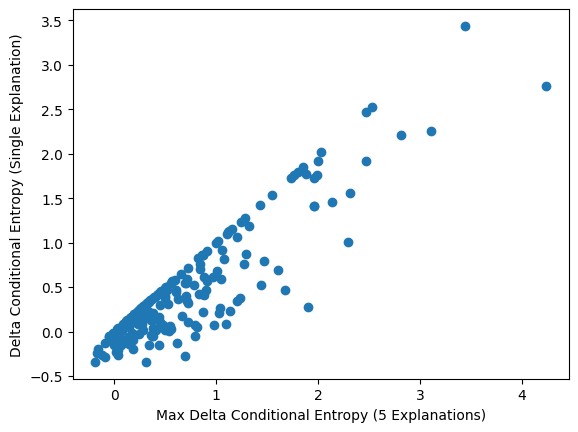

In [43]:
from scipy.stats import pearsonr
print(pearsonr(base_df["max_delta_conditional_entropy"], one_expl_df["max_delta_conditional_entropy"]))
plt.scatter(base_df["max_delta_conditional_entropy"], one_expl_df["max_delta_conditional_entropy"])
plt.xlabel("Max Delta Conditional Entropy (5 Explanations)")
plt.ylabel("Delta Conditional Entropy (Single Explanation)")
plt.show()


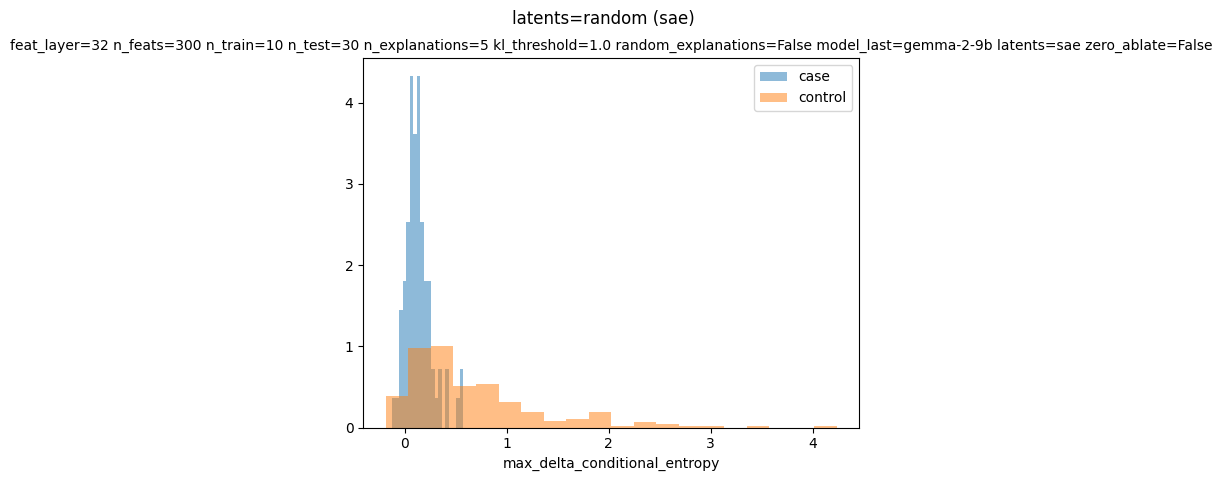

In [44]:
import matplotlib.pyplot as plt

cfg = base_cfg.copy()
case_cfg = base_cfg.copy()
# case_cfg["feat_layer"] = 41
case_cfg["latents"] = "random"

case_df = load_result(case_cfg)
cfg_df = load_result(cfg)

case_scores = case_df["max_delta_conditional_entropy"].values
cfg_scores = cfg_df["max_delta_conditional_entropy"].values

diff_keys = [k for k in case_cfg.keys() if case_cfg[k] != cfg[k]]


suptitle = " ".join([f"{k}={case_cfg[k]} ({cfg[k]})" for k in diff_keys])
title = " ".join([f"{k}={v}" for k, v in cfg.items()])
plt.hist(case_scores, bins=20, alpha=0.5, label="case", density=True)
plt.hist(cfg_scores, bins=20, alpha=0.5, label="control", density=True)
plt.suptitle(suptitle)
plt.title(title, fontsize=10)
plt.xlabel("max_delta_conditional_entropy")
plt.legend()
plt.show()



In [45]:
import pandas as pd

import json
path = "counterfactual_results/gpaolo_l32_input_scores.json"
with open(path, "r") as f:
    data = json.load(f)

input_df = pd.DataFrame([{"feat_idx": int(k.split("feature")[-1]), "feat": k, "score": data[k]["score"], "explanations": data[k]["explanations"]} for k in data.keys()])
input_df.head()

,feat_idx,feat,score,explanations
0,226,.model.layers.32_feature226,0.965000,Temporal adverb indicating a future point in t...
1,41,.model.layers.32_feature41,0.964181,"Adverbial or existential ""there"" typically use..."
2,345,.model.layers.32_feature345,0.963727,"Hyperlinks and web references, often denoted a..."
3,285,.model.layers.32_feature285,0.963542,Interrogative sentences starting with the word...
4,85,.model.layers.32_feature85,0.959737,"Periods at the end of website URLs, publicatio..."


In [46]:
# plots I want:
# score vs layer at each KL thresh and zero-ablation (show avg kl div)
# "" for random sae
# "" for random explanations
# output score vs input score for l32, for each KL thresh and zero-ablation

File not found for {'feat_layer': 16, 'n_feats': 300, 'n_train': 10, 'n_test': 30, 'n_explanations': 5, 'kl_threshold': 0.33, 'random_explanations': False, 'model_last': 'gemma-2-9b', 'latents': 'sae', 'zero_ablate': False}: File counterfactual_results/nf=300_fl=16_nt=10_nt=30_ne=5_kt=0.33_re=False_l=sae_gemma-2-9b/generations_scores.json does not exist
File not found for {'feat_layer': 24, 'n_feats': 300, 'n_train': 10, 'n_test': 30, 'n_explanations': 5, 'kl_threshold': 0.33, 'random_explanations': False, 'model_last': 'gemma-2-9b', 'latents': 'sae', 'zero_ablate': False}: File counterfactual_results/nf=300_fl=24_nt=10_nt=30_ne=5_kt=0.33_re=False_l=sae_gemma-2-9b/generations_scores.json does not exist
File not found for {'feat_layer': 32, 'n_feats': 300, 'n_train': 10, 'n_test': 30, 'n_explanations': 5, 'kl_threshold': 0.33, 'random_explanations': False, 'model_last': 'gemma-2-9b', 'latents': 'sae', 'zero_ablate': False}: File counterfactual_results/nf=300_fl=32_nt=10_nt=30_ne=5_kt=0.

/home/alex/.conda/envs/autointerp/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.conda/envs/autointerp/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


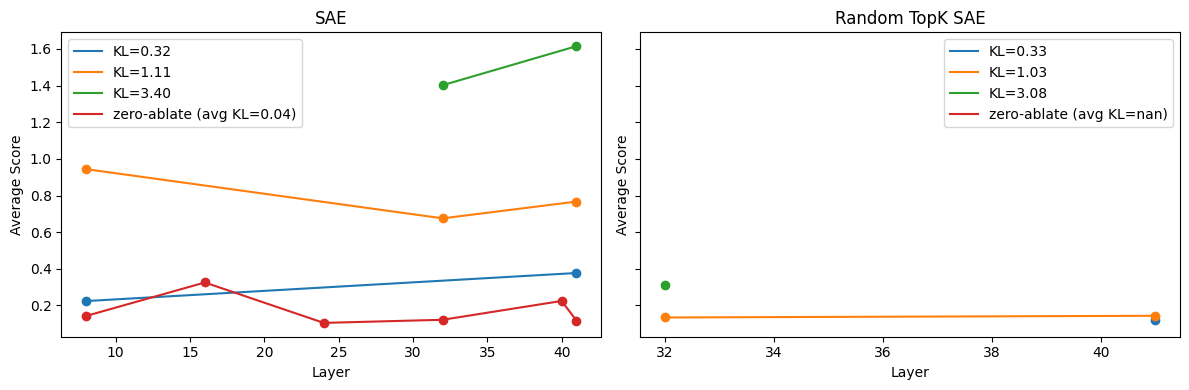

In [47]:
import numpy as np

# Score vs Layer at each KL threshold and zero-ablation
kl_thresholds = [0.33, 1.0, 3.0, None]
layers = [8, 16, 24, 32, 40, 41]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for i, latents in enumerate(["sae", "random"]):
    plt.sca(axs[i])
    for kl in kl_thresholds:
        used_layers = []
        avg_scores = []
        avg_kls = []
        for feat_layer in layers:
            cfg = base_cfg.copy()
            cfg["feat_layer"] = feat_layer
            if kl is None:    
                cfg["zero_ablate"] = True
            else:
                cfg["kl_threshold"] = kl
            cfg["latents"] = latents
            cfg["random_explanations"] = False
            try:
                df = load_result(cfg)
            except FileNotFoundError as e:
                print(f"File not found for {cfg}: {e}")
                continue
            avg_kls.append(df['avg_kl'].values.mean())
            avg_scores.append(df['max_delta_conditional_entropy'].values.mean())
            used_layers.append(feat_layer)
        label = f"zero-ablate (avg KL={np.mean(avg_kls):.2f})" if kl is None else f"KL={np.mean(avg_kls):.2f}"
        plt.plot(used_layers, avg_scores, label=label)
        plt.scatter(used_layers, avg_scores)
    plt.xlabel('Layer')
    plt.ylabel('Average Score')
    plt.legend()
    plt.title("SAE" if latents == "sae" else "Random TopK SAE")
plt.tight_layout()
plt.show()

LinregressResult(slope=np.float64(-1.6145683137756217), intercept=np.float64(1.8943960854617838), rvalue=np.float64(-0.2816568690526952), pvalue=np.float64(3.605657485292985e-05), stderr=np.float64(0.38229864740284525), intercept_stderr=np.float64(0.2904595654590725))


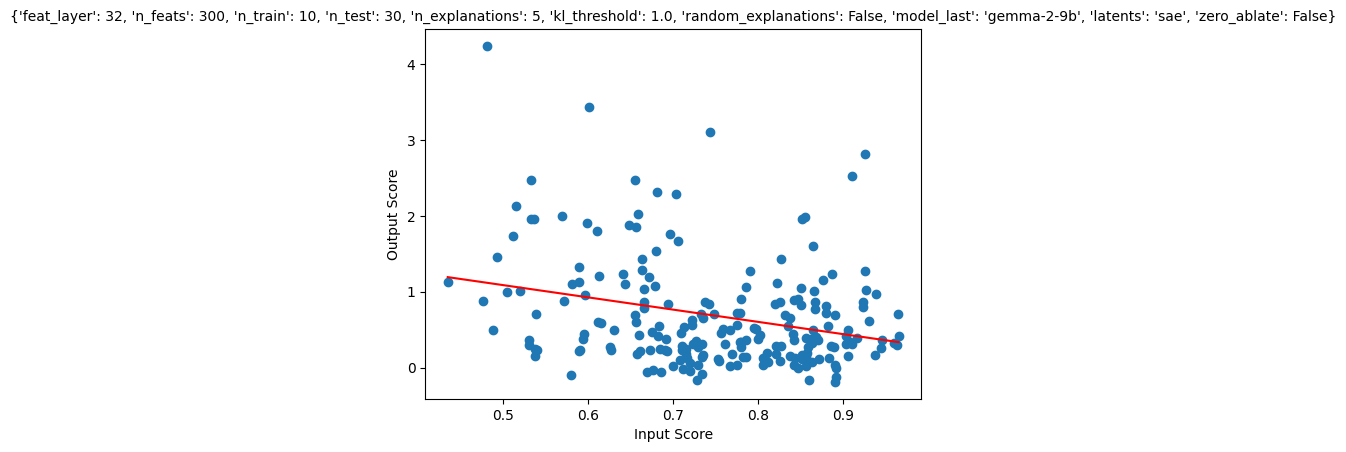

In [48]:
from scipy.stats import linregress

kl_thresh = 1.0
cfg = base_cfg.copy()
if kl_thresh is None:
    cfg["zero_ablate"] = True
else:
    cfg["kl_threshold"] = kl_thresh

df = load_result(cfg)

joined_df = input_df.merge(df, on="feat_idx")

linr = linregress(joined_df["score"], joined_df["max_delta_conditional_entropy"])
print(linr)
plt.figure()
plt.title(cfg, fontsize=10)
plt.scatter(joined_df["score"], joined_df["max_delta_conditional_entropy"])
plt.plot(joined_df["score"], linr.intercept + linr.slope * joined_df["score"], color="red")
plt.xlabel("Input Score")
plt.ylabel("Output Score")
plt.show()


In [59]:
df[:10]

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explainer_examples,explanations,explainer_prompts,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
162,233.856605,1.021721,231,"[<bos>\n""There is one huge limitation though: ...","[{'text': ' ""There is one huge limitation thou...","[{'prompt': ' as we drifted off, the silence o...","[<bos> as we drifted off, the silence of the h...","[the word ""by"", by, by, naturalness, by]","[ as we drifted off, the silence of the hours ...","{'explanation': None, 'intervention_examples':...","{'the word ""by""': 4.2367214362, 'by': 2.764714...","{'the word ""by""': 0.5354849555, 'by': 0.365623...",4.236721,"the word ""by"""
109,381.299950,0.965407,157,"[<bos>, Sports, Sports News Copyright © 2013 b...","[{'text': ', Sports, Sports News Copyright © 2...","[{'prompt': ' Record\nUnfortunately, the track...","[<bos> Record\nUnfortunately, the track record...","[reputation, reputation, name, good, reputatio...","[ Record\nUnfortunately, the track record for ...","{'explanation': None, 'intervention_examples':...","{'reputation': 3.4384611368, 'reputation, name...","{'reputation': 0.7963010966, 'reputation, name...",3.438461,reputation
152,323.166414,1.048909,220,"[<bos> flags for a dollar, <bos>.Cost Details:...","[{'text': ' flags for a dollar', 'max_act': 13...",[{'prompt': ' the required permits before ente...,[<bos> the required permits before entering th...,"[additional, extra, fees, charge, nominal, add...",[ the required permits before entering the par...,"{'explanation': None, 'intervention_examples':...","{'additional, extra, fees, charge, nominal': 2...","{'additional, extra, fees, charge, nominal': 0...",3.102204,"additional, extra, fee, charge, up<|end_of_tex..."
114,423.227822,1.012316,167,"[<bos> came in, <bos>. So, why am I bringing G...","[{'text': ' came in', 'max_act': 12.875, 'comp...","[{'prompt': ' into our', 'top_p_increases': [0...","[<bos> into our, <bos> class length was shorte...","[play, being, focus, view, contact, playing, b...","[ into our, class length was shortened to one...","{'explanation': None, 'intervention_examples':...","{'play, being, focus, view, contact': 2.210462...","{'play, being, focus, view, contact': 0.505072...",2.812222,play
76,152.849200,1.019396,112,[<bos> thinners') such as warfarin (Coumadin);...,[{'text': ' thinners') such as warfarin (Couma...,"[{'prompt': ' Middle Eastern, Mexican, Indian,...","[<bos> Middle Eastern, Mexican, Indian, Chines...","[more, much, many, so, even, the word ""more"", ...","[ Middle Eastern, Mexican, Indian, Chinese, Vi...","{'explanation': None, 'intervention_examples':...","{'more, much, many, so, even': 1.6289652983, '...","{'more, much, many, so, even': 0.4027208491, '...",2.526357,"the word ""more"""
69,350.586790,1.032325,102,[<bos>\nShare this:EmailPrintFacebookTwitterLi...,[{'text': ' Share this:EmailPrintFacebookTwitt...,[{'prompt': '. Sadly the band split soon after...,[<bos>. Sadly the band split soon after with d...,"[solo, solo, individual, solo, alone, individu...",[. Sadly the band split soon after with drumme...,"{'explanation': None, 'intervention_examples':...","{'solo': 2.4402137041, 'solo, individual': 1.9...","{'solo': 0.5727752789, 'solo, individual': 0.4...",2.472810,solo and individual
207,391.636679,0.975858,293,"[<bos> sauce. Not having burnt ends, <bos>Nati...","[{'text': ' sauce. Not having burnt ends', 'ma...",[{'prompt': ' sweet little preschool student. ...,[<bos> sweet little preschool student. Was it ...,"[leftovers, leftovers, leftovers, leftovers, l...",[ sweet little preschool student. Was it a hin...,"{'explanation': None, 'intervention_examples':...",{'leftovers': 2.464757669},{'leftovers': 0.6124664057},2.464758,leftovers
210,261.788171,1.067831,297,"[<bos> will achieve excellence in land,\nwater...","[{'text': ' will achieve e

In [63]:
joined_df[joined_df["feat_idx"] == 157].explanations_x.iloc[0]

'Possessive pronouns, articles, and indefinite articles that are used to show ownership, relation, or specificity, often preceding a noun or a noun phrase.'

In [55]:
df.iloc[1].completions

[{'text': ', Sports, Sports News Copyright © 2013 by Issaquah Press Inc. All rights reserved. This',
  'max_act': 10.25,
  'completions': {'clean': ', Sports, Sports News Copyright © 2013 by Issaquah Press Inc. All rights reserved. This document is made available for the private study',
   'intervened': ', Sports, Sports News Copyright © 2013 by Issaquah Press Inc. All rights reserved. This reputation for excellence in high-quality workmanship'}},
 {'text': ' work, I had a different preceptor and too many different people telling me what to do and how they do it. No consistency, so how can I be expected to know what is the right or wrong way to do things? Anyway, I’m afraid that this employer is now',
  'max_act': 57.0,
  'completions': {'clean': ' work, I had a different preceptor and too many different people telling me what to do and how they do it. No consistency, so how can I be expected to know what is the right or wrong way to do things? Anyway, I’m afraid that this employer is 

In [65]:
for pa in Path("counterfactual_results").glob("*/generations_scores.json"):
    print(pa)
    new_name = pa.parent / pa.name.replace(".json", "_dup_prompt.json")
    pa.rename(new_name)

counterfactual_results/nf=300_fl=41_nt=10_nt=30_ne=5_kt=3.0_re=False_l=random_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=8_nt=10_nt=30_ne=5_kt=0.033_re=False_l=sae_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=8_nt=10_nt=30_ne=5_kt=1.0_re=False_l=random_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=24_nt=10_nt=30_ne=5_re=False_l=sae_za=True_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=8_nt=10_nt=30_ne=5_kt=0.033_re=False_l=random_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=16_nt=10_nt=30_ne=5_kt=0.1_re=False_l=sae_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=8_nt=10_nt=30_ne=5_kt=0.1_re=False_l=random_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=32_nt=10_nt=30_ne=5_kt=3.0_re=False_l=random_gemma-2-9b/generations_scores.json
counterfactual_results/nf=300_fl=16_nt=10_nt=30_ne=5_re=False_l=sae_za=True_gemma-2-9b/generations_score